# Figure 3: Relative % change in $R_*$ versus r

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve

### Importing required scripts

In [2]:
import importlib
import R_star_construct
import Keeling_model

importlib.reload(R_star_construct)
importlib.reload(Keeling_model)

Rstar = R_star_construct.Rstar
Rstar_solve = R_star_construct.Rstar_solve
RstarAnal = R_star_construct.RstarAnal
ConfigsConstruct = Keeling_model.ConfigsConstruct

### Parameters

In [3]:
h2 = 2520                    # no. of households in neighbourhood 2
n2 = 2                       # size of households for neighbourhood 2
Inf1,Inf2 = 1,0              # initial no. of infections in each neighbourhood
gamma = 0.2                  # recovery rate from infection
N2 = 5040                    # Neighbourhood (2) population size
N_neigh = 2                  # no. of neighbourhoods

In [4]:
## fixing contact rates alpha and beta

nu = 3      # good range 1 to 6
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]
alpha = beta/nu
alpha=round(alpha,2)
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

### Producing figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


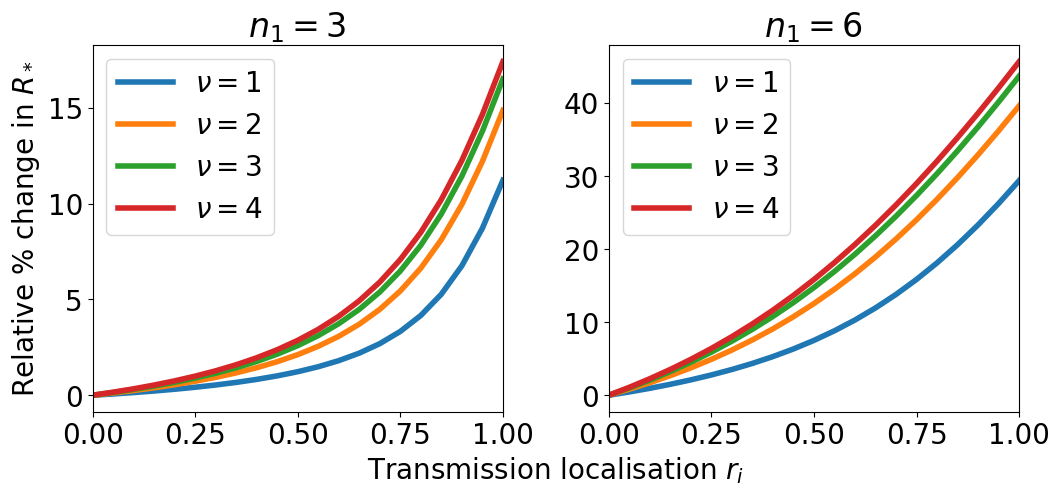

In [5]:
figure=plt.figure(figsize=(11,5)) # fig size
plt.rcParams.update({'font.size': 20})

pvec = np.arange(0,1.05,0.05)     # list of r values
nuvec = [1,2,3,4]                 # list of nu values
betavec = [fsolve(RstarAnal,0.5,(gamma,nus))[0] for nus in nuvec]    # list of beta values fixed for rho=0.5 and R_*=2.4 and specified nu
lines = len(nuvec)     # no. of curves per figure
n1vec = [3,6]          # household size neighbourhood 1 in figure 1 and 2 respectively
h1vec = [1680,840]     # no. of households in neighbourhood 1 in figure 1 and 2 respectively
plots = len(n1vec)     # no. of plots

for plot in range(plots):          # looping over plots
    plt.subplot(1,plots,plot+1)
    
    n1 = n1vec[plot]                            # household size neighbourhood 1
    h1 = h1vec[plot]                            # household size neighbourhood 2
    H = np.array([h1,h2])                       # array of number of households in each neighbourhood
    N = np.array([n1,n2])                       # array of household size for each neighbourhood
    
    configs1,n_configs1 = ConfigsConstruct(n1)  # defining the set of household configurations, neighbourhood 1
    configs2,n_configs2 = ConfigsConstruct(n2)  # neighbourhood 2
    
    y0 = np.zeros(n_configs1+n_configs2)     # state space is each of the possible household configurations accross the 2 neighbourhoods
    y0[0] = (h1 - Inf1)/h1                   # propn of households neighbourhood 1 made up of susceptibles only
    y0[1] = Inf1/h1                          # propn of households neighbourhood 1 with one initial infected
    y0[n_configs1] = (h2 - Inf2)/h2          # propn of households neighbourhood 2 made up of susceptibles only
    y0[n_configs1+1] = Inf2/h2               # propn of households neighbourhood 2 with one initial infected
   
    for line in range(lines):          # looping over curves for each figure
        nu = nuvec[line]               # nu value
        beta = betavec[line]           # beta value
        alpha = beta/nu                # alpha value
    
        R_star = np.zeros(len(pvec))     # initialising arrays to store R_star and it's components
        R1star = np.zeros(len(pvec))
        R2star = np.zeros(len(pvec))
        R11 = np.zeros(len(pvec))
        R12 = np.zeros(len(pvec))
        R21 = np.zeros(len(pvec))
        R22 = np.zeros(len(pvec))
        # calculating R_* for proportional mixing (rho=0.5)
        RstarFix = Rstar(n1=n1,n2=n2,beta1=beta,beta2=beta,alpha1=alpha,alpha2=alpha,rho1=0.5,rho2=0.5,gamma=gamma,y0=y0)[0]

        for i in range(len(pvec)):                      # looping over the range of r values
            p_reserve = np.array([pvec[i],pvec[i]])
            rho = np.zeros((N_neigh,N_neigh))           # initialising array to store rho values each iteration
            
            if pvec[i] == 1:           # if r=1, use separate case to avoid division by 0
                rho[0,0] = 1
                rho[1,1] = 1
            else:
                for k in range(N_neigh):          # define rho from r
                    for j in range(N_neigh):
                        rho[k,j] = (1-p_reserve[k])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
                    rho[k,k] = p_reserve[k] + (1-p_reserve[k])*(1-p_reserve[k])*H[k]*N[k]/(np.sum((1-p_reserve)*H*N))
            
            # calculate R* and it's components
            R_star[i],R11[i],R12[i],R21[i],R22[i] = Rstar(n1=n1,n2=n2,beta1=beta,beta2=beta,alpha1=alpha,alpha2=alpha,rho1=rho[0,0],rho2=rho[1,1],gamma=gamma,y0=y0)
            R1star[i] = R11[i] + R21[i]
            R2star[i] = R12[i] + R22[i]
    
        plt.plot(pvec,100*(R_star-RstarFix)/RstarFix, label=r'$\nu=${}'.format(nu),linewidth=4)   # plotting rel change in R_* for specific nu

        if plot == 0:
            plt.ylabel(r'Relative % change in $R_*$') 
        plt.legend()
        plt.title(r'$n_1=${}'.format(n1))
        plt.xticks([0,0.25,0.5,0.75,1])
        plt.xlim(0,1)
        plt.tight_layout()
        
figure.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
plt.xlabel(r'Transmission localisation $r_i$')
plt.savefig('rel_Rstar.pdf')

The relative change in the value of the household reproduction number $R_*$ as localisation is increased in the two neighbourhoods from proportional mixing to complete isolation. In both plots $n_2=2$ but household size in neighbourhood $1$ differs. Each curve represents a different within-household versus between scaling factor. $\nu=1,2,3,4$ corresponds to the blue, orange, green and red lines respectively.